# Stochastic Policy Approach (PPO-GAE)

Implementing a stochastic policy approach to solve the OpenAI Gym's LunarLander (Continuous Actions) problem, "LunarLanderContinuous-v2". This notebook details the Proximal Policy Optimization (PPO) with Generalized Advantage Estimation (GAE) approach.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

## Setting Up the Environment

Initializing the LunarLanderContinuous-v2 environment with multiple parallel instances for efficient training.

In [2]:
# Set the environment name for the Gym environment
env_name = 'LunarLanderContinuous-v2'

# Setting up the number of parallel environments to be used
nenvs = 6  

# Create the Gym environment with the specified number of parallel environments
env = gym.vector.make(env_name, num_envs=nenvs, asynchronous=False)

## Defining Hyperparameters and Variables

In [3]:
# Define the Hyperparameters

# Discount factor for future rewards 
gamma = 0.99
# Lambda parameter for GAE
lmbda = 0.95
# Epsilon parameter
epsilon = 0.2
# Size of the batch for training the neural network
batchsize = 64
# Number of times to repeat the training process per epoch
epoch_repeat = 10

# Define the Variables

# Flag to indicate whether the problem is solved
solved = False
# The reward threshold at which the environment is considered solved
solved_reward = 195
# List to store rewards of the last 10 epochs
last_10_epoch_rewards = []
# Deque to store the rewards of the most recent 50 episodes (for tracking performance)
results = deque(maxlen=50)
# List to store average rewards per epoch (for analysis and visualization)
average_rewards = []
# Array to accumulate total rewards for each environment instance
totreward = np.zeros(nenvs)
# Counter for the number of steps taken in the environment
stepcount = 0
# Counter for the number of training epochs completed
epoc = 0
# Reset the environment and get the initial observation/state
obs, _ = env.reset()

## Setting Up Model Saving Path

Defining and preparing the file path for saving the average score data of the model. 

In [4]:
# Define the path for saving average score data
folder_path = 'average_scores_experiment_2/'

# Check if the directory for average scores exists
if not os.path.exists(folder_path):
    # If the directory does not exist, create it
    os.makedirs(folder_path)

## Defining Actor and Critic Networks

Creating neural network architectures for the Actor and Critic components of the PPO-GAE algorithm.

In [5]:
# Actor Network Definition
class ActorNet(nn.Module):
    def __init__(self, input_size, hidden_units=64, output_size=2):
        super(ActorNet, self).__init__()
        # Neural network layers
        self.model = nn.Sequential(
            # First linear layer
            nn.Linear(input_size, hidden_units), 
             # Tanh activation function
            nn.Tanh(),     
            # Second linear layer
            nn.Linear(hidden_units, int(hidden_units/2)), 
            # Tanh activation function
            nn.Tanh()                            
        )
        # Output layer for mean of action distribution
        self.mu_head = nn.Linear(int(hidden_units/2), output_size)
        # Output layer for standard deviation of action distribution
        self.logstd_head = nn.Linear(int(hidden_units/2), output_size)

    def forward(self, x):
        x = self.model(x)
        # Get mean of action distribution
        loc = torch.tanh(self.mu_head(x)) * 2  
        # Get standard deviation of action distribution
        scale = torch.exp(self.logstd_head(x))  
        return loc, scale

# Critic Network Definition
class CriticNet(nn.Module):
    def __init__(self, input_size, hidden_units=64, output_size=2):
        super(CriticNet, self).__init__()
        # Neural network layers
        self.model = nn.Sequential(
            # First linear layer
            nn.Linear(input_size, hidden_units),  
            # Tanh activation function
            nn.Tanh(),      
            # Second linear layer
            nn.Linear(hidden_units, int(hidden_units/2)),  
            # Tanh activation function
            nn.Tanh()                             
        )
        # Output layer for value function
        self.value_head = nn.Linear(int(hidden_units/2), 1)

    def forward(self, x):
        x = self.model(x)
        # Get value function output
        value = self.value_head(x)  
        return value

    def __call__(self, x):
        # Call forward method
        out = self.forward(x)  
        return out

## Initializing Networks and Optimizers

Instantiating Actor and Critic models along with their respective optimizers for the training process.

In [6]:
# Get the observation and action space dimensions from the environment

# Observation space dimension
obs_dim = env.single_observation_space.shape[0]  
# Action space dimension
n_acts = env.single_action_space.shape[0]     
# Size of hidden layers in neural networks
hidden_sizes = 64 

# Instantiate the Actor network
actor_net = ActorNet(obs_dim, hidden_sizes, n_acts)
# Instantiate the Critic network with Output size 1
critic_net = CriticNet(obs_dim, hidden_sizes, 1) 

# Initialize Optimizers

# Optimizer for the Actor network parameters
actor_optimizer = optim.Adam(actor_net.parameters(), lr=0.0003)
# Optimizer for the Critic network parameters
critic_optimizer = optim.Adam(critic_net.parameters(), lr=0.0003)

# Tensor Conversion Functions

# Function to convert data to a PyTorch tensor (float type)
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
# Function to convert data to a PyTorch tensor (integer type)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

## Implementing Running Memory

Setting up a running memory class to store and process experiences collected during environment interactions.

In [7]:
class RunningMem():
    def __init__(self):
        # Initialize the memory by calling the reset method
        self.reset()

    def store(self, obs, action, logprob, reward, done, obs_, values, values_):
        # Store the experience in the memory
        # Store observations
        self.obs.append(obs)    
        # Store actions
        self.actions.append(action.unsqueeze(-1))  
        # Store log probabilities of actions
        self.logprobs.append(logprob)    
        # Store rewards
        self.rewards.append(reward.unsqueeze(-1))  
        # Store done flags (episode termination flags)
        self.dones.append(done.unsqueeze(-1))  
        # Store next observations
        self.obs_.append(obs_)     
        # Store values (from critic)
        self.values.append(values)   
        # Store next values (from critic)
        self.values_.append(values_)              

    def batches(self, batchsize):
        # Create batches of experiences for training
        # Total number of experiences to sample
        size = nenvs * memsteps                   
        idx = list(range(size))
        # Shuffle indices for random sampling
        random.shuffle(idx)                       

        # Stack experiences into tensors
        b_obs = torch.stack(self.obs)
        b_actions = torch.stack(self.actions)
        b_logprobs = torch.stack(self.logprobs)
        b_rewards = torch.stack(self.rewards)
        b_dones = torch.stack(self.dones)
        b_obs_ = torch.stack(self.obs_)
        b_values = torch.stack(self.values)
        b_values_ = torch.stack(self.values_)

        # Calculate Generalized Advantage Estimation (GAE)
        gaes = []
        # Initialize GAE
        gae = T(np.zeros(nenvs)).view(nenvs, -1)  
        for i in range(len(b_obs) - 1, -1, -1):
            delta = b_rewards[i] + gamma * b_values_[i] * (1 - b_dones[i]) - b_values[i]
            gae = delta + gamma * lmbda * (1 - b_dones[i]) * gae
            gaes.insert(0, gae)

        # Reshape tensors for batching
        b_obs = b_obs.view(size, -1)
        b_actions = b_actions.view(size, -1)
        b_logprobs = b_logprobs.view(size, -1)
        b_rewards = b_rewards.view(size, -1)
        b_dones = b_dones.view(size, -1)
        b_obs_ = b_obs_.view(size, -1)
        b_values = b_values.view(size, -1)
        b_values_ = b_values_.view(size, -1)
        b_gae = torch.stack(gaes).view(size, -1)

        # Yield mini-batches of experiences
        for batchn in range(0, len(idx), batchsize):
            batchidx = idx[batchn:batchn+batchsize]
            batchidx = Ti(batchidx)
            mb_obs = torch.index_select(b_obs, 0, batchidx)
            mb_actions = torch.index_select(b_actions, 0, batchidx)
            mb_logprobs = torch.index_select(b_logprobs, 0, batchidx)
            mb_rewards = torch.index_select(b_rewards, 0, batchidx)
            mb_dones = torch.index_select(b_dones, 0, batchidx)
            mb_obs_ = torch.index_select(b_obs_, 0, batchidx)
            mb_values = torch.index_select(b_values, 0, batchidx)
            mb_values_ = torch.index_select(b_values_, 0, batchidx)
            mb_gae = torch.index_select(b_gae, 0, batchidx)
            yield mb_obs, mb_actions, mb_logprobs, mb_rewards, mb_dones, mb_obs_, mb_values, mb_values_, mb_gae
            
    def reset(self):
        # Reset the memory
        # List to store observations
        self.obs = []   
        # List to store actions
        self.actions = []  
        # List to store log probabilities of actions
        self.logprobs = [] 
        # List to store rewards
        self.rewards = [] 
        # List to store done flags
        self.dones = []    
        # List to store next observations
        self.obs_ = []    
        # List to store values
        self.values = []   
        # List to store next values
        self.values_ = []  
        # List to store Generalized Advantage Estimations
        self.gae = []      

## Training Function and Action Simulation

Defining the training loop and a function to simulate actions using the policy network.

In [8]:
@torch.no_grad()
def sim_action(policy, obs):
    # Get the action distribution parameters (mean and standard deviation) from the policy network
    loc, std = policy(T(obs))
    
    # Create a normal distribution for action selection
    dist = Normal(loc=loc, scale=std + 1e-6)
    
    # Sample an action from the distribution
    action = dist.sample()
    
    # Compute the log probability of the selected action
    action_log_prob = torch.sum(dist.log_prob(action), dim=-1, keepdim=True)
    
    return action, action_log_prob

def train(mem, gamma=0.99, batchsize=10, epoch_repeat=20, epsilon=0.2, lmbda=0.95):
    # Train the model for a specified number of epochs
    for epochrep in range(epoch_repeat):
        # Iterate over batches of experiences
        for batch in mem.batches(batchsize=batchsize):
            # Unpack the batch
            obs, actions, logprobs, rewards, dones, obs_, values, values_, gae = batch
            
            # Normalize Generalized Advantage Estimation (GAE)
            gae = (gae - torch.mean(gae)) / (torch.std(gae) + 1e-6)
            
            # Calculate the target for the value function
            target = gae + values
            
            # Compute the value of the current states
            state_values = critic_net(obs)
            
            # Calculate the critic loss
            critic_loss = F.smooth_l1_loss(state_values, target).mean()

            # Get the new action distribution parameters from the actor network
            new_loc, new_scale = actor_net(obs)
            dist = Normal(loc=new_loc, scale=new_scale + 1e-6)
            
            # Compute the new log probabilities of the actions
            new_logprobs = torch.sum(dist.log_prob(actions), dim=-1, keepdim=True)
            
            # Calculate the ratio (rho) of new and old probabilities
            rho = torch.exp(new_logprobs - logprobs)
            
            # Compute the surrogate losses
            surrgt1 = rho * gae
            surrgt2 = rho.clamp(1 - epsilon, 1 + epsilon) * gae
            
            # Calculate the policy loss
            policy_loss = -torch.minimum(surrgt1, surrgt2).mean()

            # Compute the total loss and perform backpropagation
            loss = policy_loss + 0.5 * critic_loss
            actor_optimizer.zero_grad()
            critic_optimizer.zero_grad()
            loss.backward()
            actor_optimizer.step()
            critic_optimizer.step()

# Memory steps and initialization
memsteps = 500
mem = RunningMem()

## The Training Loop

Executing the main training loop.

In [9]:
while True:
    stepcount += 1
    # Generate action and its log probability from the current policy
    action, action_log_prob = sim_action(actor_net, obs)
    
    # Execute the action in the environment and get the next observation and other info
    next_obs, reward, terminated, truncated, _ = env.step(action.numpy())
    
    # Check if the episode has ended
    done = terminated | truncated
    
    with torch.no_grad():
        # Get the value of the current and next state from the critic network
        values = critic_net(T(obs))
        values_ = critic_net(T(next_obs))
    
    # Store the experience in the memory
    mem.store(T(obs), action, action_log_prob, T(reward), Ti(done), T(next_obs), values, values_)
    
    # Update the observation
    obs = next_obs
    
    # Update the total reward
    totreward += reward
    
    # Check for episodes that have finished
    doneidx = np.where(done == True)
    for k in doneidx[0]:
        # Store the total reward and reset it for the next episode
        results.append(totreward[k])
        last_10_epoch_rewards.append(totreward[k])  # Add reward to last 10 epochs list
        totreward[k] = 0

    # Perform training every 'memsteps' steps
    if stepcount > 1 and stepcount % memsteps == 0:
        epoc += 1
        # Train the networks using the stored experiences
        train(mem, gamma=gamma, batchsize=batchsize, epoch_repeat=epoch_repeat, epsilon=epsilon, lmbda=lmbda)
        # Reset the memory after training
        mem.reset()

        # Calculate and print the average reward every 10 epochs
        if epoc % 10 == 0:
            avg_last_10_epochs = np.mean(last_10_epoch_rewards[-10:])
            print(f'Episode: {epoc}, Average Reward (Average last 10 Episodes): {avg_last_10_epochs}')

            # Ensure there are at least 50 epochs before checking if solved
            if len(results) >= 50:
                avg_reward = np.mean(list(results)[-50:])
                average_rewards.append(avg_reward)

                # Check if the average reward of last 50 episodes meets the solved criterion
                if avg_reward >= solved_reward and not solved:
                    print("*" * 125)
                    print(f'Solved! Episode: {epoc}, Average Score Last 50 Episodes: {avg_reward}')
                    print("*" * 125)
                    solved = True
                    # Save the model or perform any additional actions here
                    break
                    
# Save average reward to file
np.save(folder_path + 'average_scores_stochastic.npy', np.array(average_rewards))

# Close the environment after training
env.close()

Episode: 10, Average Reward (Average last 10 Episodes): -63.49588937404508
Episode: 20, Average Reward (Average last 10 Episodes): -24.52138302586774
Episode: 30, Average Reward (Average last 10 Episodes): 53.79230041306694
Episode: 40, Average Reward (Average last 10 Episodes): 55.94290085536255
Episode: 50, Average Reward (Average last 10 Episodes): -18.089579036340304
Episode: 60, Average Reward (Average last 10 Episodes): 52.65370827871105
Episode: 70, Average Reward (Average last 10 Episodes): 100.59703819379031
Episode: 80, Average Reward (Average last 10 Episodes): 83.74899131373184
Episode: 90, Average Reward (Average last 10 Episodes): 202.16555568589675
Episode: 100, Average Reward (Average last 10 Episodes): 167.99764196082188
Episode: 110, Average Reward (Average last 10 Episodes): 125.6696562550026
Episode: 120, Average Reward (Average last 10 Episodes): 145.81666099378054
Episode: 130, Average Reward (Average last 10 Episodes): 118.24941731542398
Episode: 140, Average Rew

## Training Progress Visualization

Visualizing the training progress with a plot of the average reward per episode (Y-axis) against the number of episodes (X-axis).

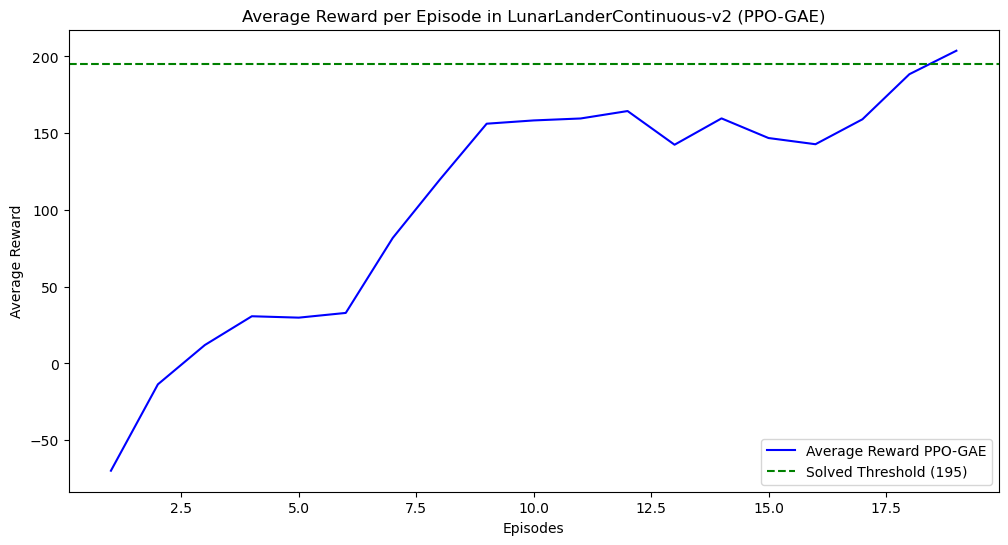

In [10]:
# Creating the plot

# Generate a range of episode numbers for the x-axis
episode_numbers = list(range(1, len(average_rewards) + 1))

plt.figure(figsize=(12, 6))

# Plot average rewards per episode
plt.plot(episode_numbers, average_rewards, label='Average Reward PPO-GAE', color='blue')

# Add a horizontal line representing the solved threshold
plt.axhline(y=solved_reward, color='green', linestyle='--', label='Solved Threshold (195)')

# Set labels for x and y axes
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

# Display the plot
plt.title('Average Reward per Episode in LunarLanderContinuous-v2 (PPO-GAE)')
plt.legend()
plt.show()